In [25]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import lightgbm
import imblearn

from collections import Counter
from glob import glob
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

import utils.merge_tools as M

## Load Data and Preprocess

In [26]:
# Read base file
base_file_path = '../data/raw/parquet_files/train/train_base.parquet'
base_df = pl.read_parquet(base_file_path).pipe(M.set_table_dtypes)

# Convert dates
base_df = pl.concat([base_df, M.separate_dates(base_df, ['date_decision'])], how='horizontal')
base_df = base_df.drop(['date_decision', 'MONTH'])

In [27]:
data_dir = '../data/raw/parquet_files/train'
cb_a_1_paths = glob(os.path.join(data_dir, 'train_credit_bureau_a_1') + '*')

# Combine all files in cb_a_1 group
df = pl.DataFrame()
for path in cb_a_1_paths:
    df = pl.concat([df, pl.read_parquet(path).pipe(M.set_table_dtypes)], how='vertical')

In [28]:
# Separate personal from non-personal
df_per = base_df.join(df.filter(pl.col('num_group1') == 0), on='case_id', how='left')
df_non = base_df.join(df.filter(pl.col('num_group1') != 0), on='case_id', how='left')

### Personal Data

Preprocessing:

- Add columns indicating null values by column
- Add date `year`, `month`, `day` columns for each date column
- Split off personal and non-personal data
- Drop columns with excessive missing values

In [29]:
# Create columns indicating null values for non-string/cat
df_is_nulls = M.create_is_null_cols(df_per)

# Convert dates to numerical
date_cols = [ col for col in df_is_nulls.columns if df_is_nulls[col].dtype == pl.Date ]
df_dates_sep = pl.concat([df_is_nulls, M.separate_dates(df_is_nulls, date_cols)], how='horizontal')
df_dates_sep = df_dates_sep.drop(date_cols)

In [30]:
df_is_nulls.shape, df_dates_sep.shape

((1526659, 151), (1526659, 175))

In [31]:
missing_thresh = 0.95 * df_dates_sep.height

per_keep_cols_mask = (df_dates_sep.null_count() < missing_thresh).to_numpy().tolist()[0]
per_keep_list = [ col for col, keep in zip(list(df_dates_sep.columns), per_keep_cols_mask) if keep ]
df_per_filtered = df_dates_sep.select(per_keep_list)

## Impute

Further imputations and transformations will be fit on the training set.

In [32]:
ignore_cols = ['case_id', 'target', 'num_group1']

# Polars to Pandas does not implicitly cast pl.Boolean to bool
bool_cols = [ col for col in df_per_filtered.columns if df_per_filtered[col].dtype == pl.Boolean ]

X = df_per_filtered.drop(ignore_cols).to_pandas()
y = df_per_filtered['target'].to_pandas().values

# Convert booleans
for col in bool_cols:
    X[col] = X[col].astype('bool')

X_per_train, X_per_val, y_per_train, y_per_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=28
)

In [33]:
# Get top 5 categories by column, ignores null
top_cat_dict = M.get_top_n_categories(X_per_train, 5)

# Impute 'other' and 'null'
for col, vals in top_cat_dict.items():
        X_per_train[col] = X_per_train[col].fillna('null')
        X_per_val[col] = X_per_val[col].fillna('null')
        X_per_train[col] = np.where(X_per_train[col].isin(vals), X_per_train[col], 'other')
        X_per_val[col] = np.where(X_per_val[col].isin(vals), X_per_val[col], 'other')

In [34]:
numeric_cols = X_per_train.select_dtypes(include=[np.number]).columns
X_per_train_s_imp = X_per_train.copy()
X_per_val_s_imp = X_per_val.copy()

# Imputing numerical values
median_imputer = SimpleImputer(strategy='median')
X_per_train_s_imp[numeric_cols] = median_imputer.fit_transform(X_per_train_s_imp[numeric_cols])
X_per_val_s_imp[numeric_cols] = median_imputer.transform(X_per_val_s_imp[numeric_cols])

In [35]:
X_per_train_s_imp.isna().sum().sum()

0

### One-hot Encode

In [36]:
oh_enc = OneHotEncoder(handle_unknown='ignore')
cat_cols = X_per_train_s_imp.select_dtypes(include=['object']).columns
X_per_train_oh = oh_enc.fit_transform(X_per_train_s_imp[cat_cols])
X_per_val_oh = oh_enc.transform(X_per_val_s_imp[cat_cols])
X_per_train_df = pd.DataFrame(X_per_train_oh.toarray(), columns=oh_enc.get_feature_names_out(input_features=cat_cols), index=X_per_train_s_imp.index)
X_per_val_df = pd.DataFrame(X_per_val_oh.toarray(), columns=oh_enc.get_feature_names_out(input_features=cat_cols), index=X_per_val_s_imp.index)

In [37]:
X_per_train_s_imp_oh = pd.concat([X_per_train_s_imp.drop(columns=cat_cols), X_per_train_df], axis=1)
X_per_val_s_imp_oh = pd.concat([X_per_val_s_imp.drop(columns=cat_cols), X_per_val_df], axis=1)

In [38]:
model = lightgbm.LGBMClassifier(n_estimators=500)
model.fit(X_per_train_s_imp_oh, y_per_train)

y_pred_base = model.predict(X_per_val_s_imp_oh)
y_pred_binary_base = [ 
    1 if pred > 0.5 else 0 for pred in y_pred_base
]

roc_auc = roc_auc_score(y_per_val, y_pred_base)
cm = confusion_matrix(y_per_val, y_pred_binary_base)
print('No Resampling')
print(f'ROC AUC: {roc_auc}')
print(classification_report(y_per_val, y_pred_binary_base))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 38395, number of negative: 1182932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9147
[LightGBM] [Info] Number of data points in the train set: 1221327, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.031437 -> initscore=-3.427824
[LightGBM] [Info] Start training from score -3.427824
No Resampling
ROC AUC: 0.500883494810131
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    295733
           1       0.36      0.00      0.00      9599

    accuracy                           0.97    305332
   macro avg       0.66      0.50      0.49    305332
weighted avg       0.95      0.97      0.95 

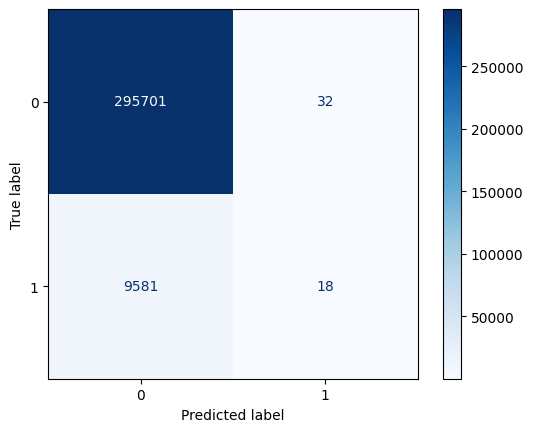

In [39]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.show()

### SMOTE

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1182932, number of negative: 1182932
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.432485 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 36056
[LightGBM] [Info] Number of data points in the train set: 2365864, number of used features: 222
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
No Resampling
ROC AUC: 0.5042970173087648
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    295733
           1       0.04      0.05      0.04      9599

    accuracy                           0.93    305332
   macro avg       0.50      0.50      0.50    305332
weighted avg       0.94      0.93      0.93    305332



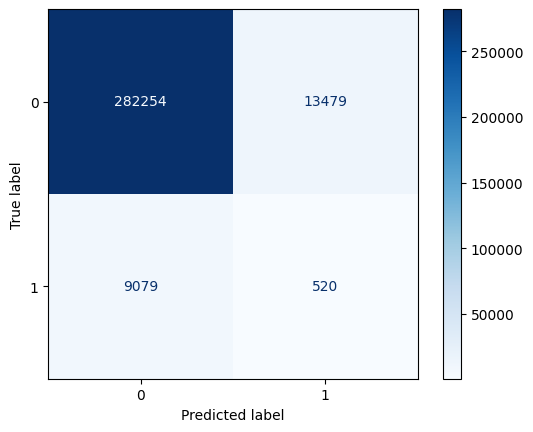

In [40]:
oversample = imblearn.over_sampling.SMOTE()
X_train_res, y_train_res = oversample.fit_resample(X_per_train_s_imp_oh, y_per_train)

model.fit(X_train_res, y_train_res)

y_pred_base = model.predict(X_per_val_s_imp_oh)
y_pred_binary_base = [ 
    1 if pred > 0.5 else 0 for pred in y_pred_base
]

roc_auc = roc_auc_score(y_per_val, y_pred_base)
cm = confusion_matrix(y_per_val, y_pred_binary_base)
print('No Resampling')
print(f'ROC AUC: {roc_auc}')
print(classification_report(y_per_val, y_pred_binary_base))

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [43]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 3,
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "n_estimators": 5000,
    "verbose": -1,
}

In [44]:
smote_results_list = []
for i in range(3, 16, 2):
    print(f'Current k-neighbors: {i}')
    sampler = imblearn.over_sampling.SMOTE(k_neighbors=i)
    X_train_res, y_train_res = sampler.fit_resample(X_per_train_s_imp_oh, y_per_train)

    lgb_train = lightgbm.Dataset(X_train_res, label=y_train_res)
    lgb_valid = lightgbm.Dataset(X_per_val_s_imp_oh, label=y_per_val, reference=lgb_train)

    model = lightgbm.train(
        params,
        lgb_train,
        valid_sets=lgb_valid,
        callbacks=[lightgbm.log_evaluation(100), lightgbm.early_stopping(100)]
    )

    preds = model.predict(X_per_val_s_imp_oh, num_iteration=model.best_iteration)
    binary_preds = [
        1 if pred > 0.5 else 0
        for pred in preds
    ]
    cm = confusion_matrix(y_per_val, binary_preds)
    roc_auc = roc_auc_score(y_per_val, preds)

    smote_dict = {
        'k_neighbors': i,
        'cm': cm,
        'roc_auc': roc_auc,
        'preds': preds
    }
    smote_results_list.append(smote_dict)

Current k-neighbors: 3


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.65234
Early stopping, best iteration is:
[37]	valid_0's auc: 0.675287
Current k-neighbors: 5


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.651173
Early stopping, best iteration is:
[36]	valid_0's auc: 0.674244
Current k-neighbors: 7


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.651083
Early stopping, best iteration is:
[37]	valid_0's auc: 0.67207
Current k-neighbors: 9


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.650866
Early stopping, best iteration is:
[24]	valid_0's auc: 0.674756
Current k-neighbors: 11


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.650953
Early stopping, best iteration is:
[26]	valid_0's auc: 0.673895
Current k-neighbors: 13


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.654342
Early stopping, best iteration is:
[23]	valid_0's auc: 0.675788
Current k-neighbors: 15


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.651934
Early stopping, best iteration is:
[23]	valid_0's auc: 0.675608


In [45]:
for samp in smote_results_list:
    print(f'k-neighbors {samp["k_neighbors"]}: ROC AUC - {samp["roc_auc"]}')

k-neighbors 3: ROC AUC - 0.6752871520352723
k-neighbors 5: ROC AUC - 0.6742439908486377
k-neighbors 7: ROC AUC - 0.6720697677143936
k-neighbors 9: ROC AUC - 0.6747560754191182
k-neighbors 11: ROC AUC - 0.6738946116778743
k-neighbors 13: ROC AUC - 0.6757881670861107
k-neighbors 15: ROC AUC - 0.6756077922340495


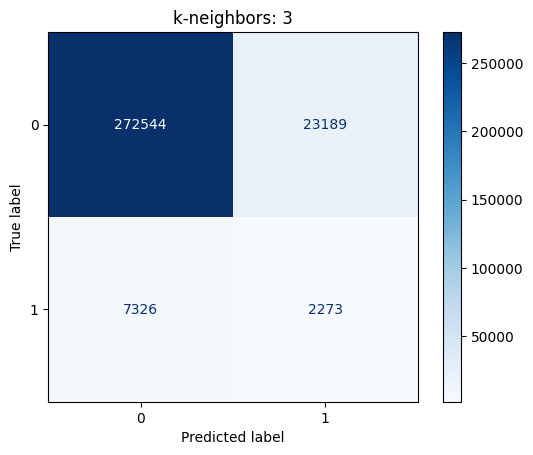

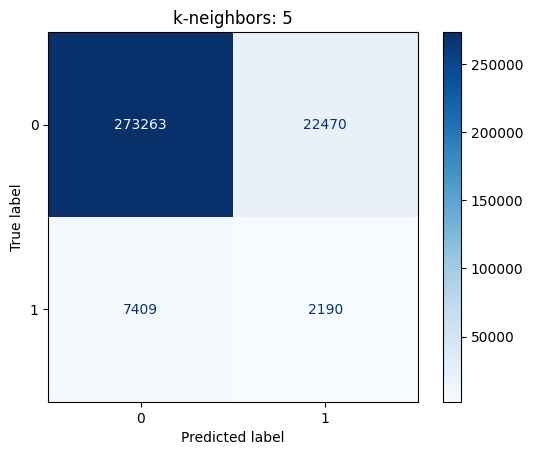

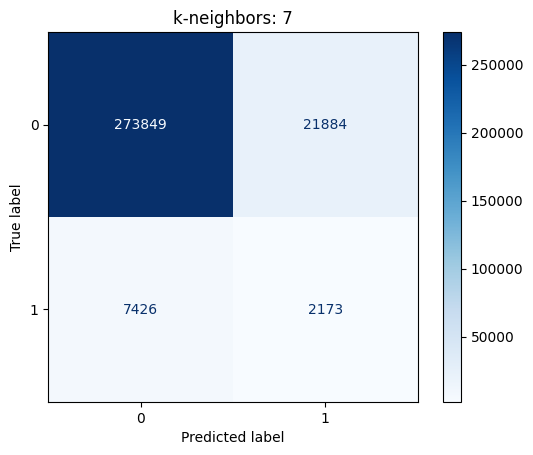

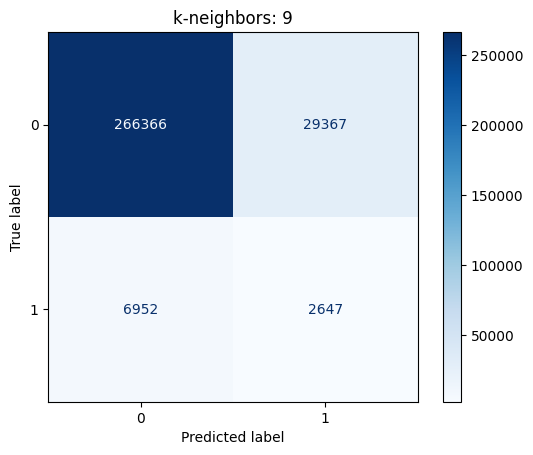

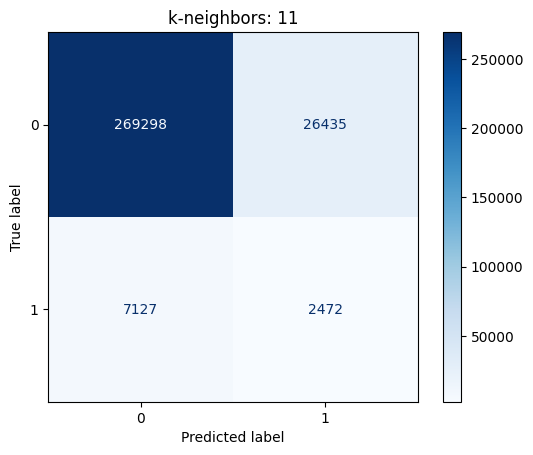

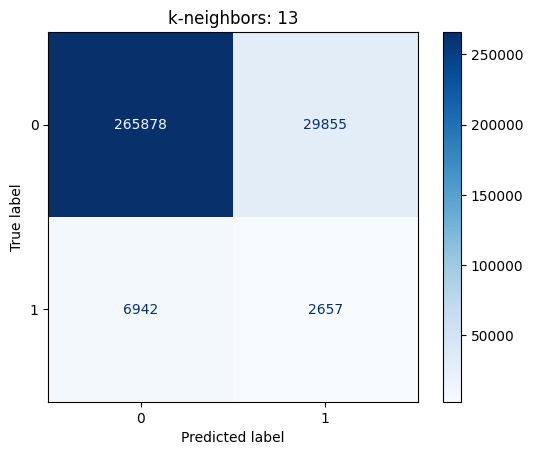

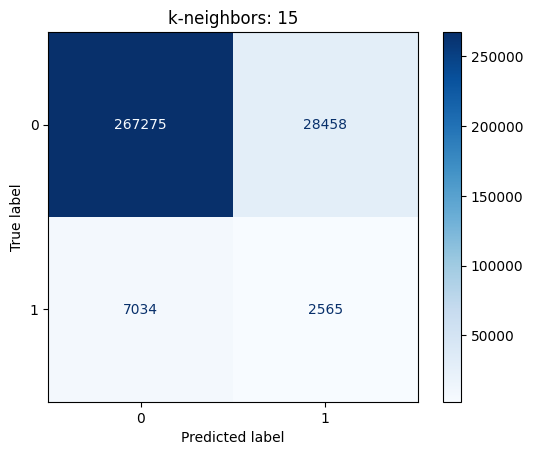

In [46]:
for samp in smote_results_list:
    disp = ConfusionMatrixDisplay(confusion_matrix=samp['cm'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'k-neighbors: {samp["k_neighbors"]}')
    plt.show()

### ADASYN

In [47]:
adasyn_results_list = []
for i in range(1, 16, 2):
    print(f'Current n-neighbors: {i}')
    sampler = imblearn.over_sampling.ADASYN(n_neighbors=i)
    X_train_res, y_train_res = sampler.fit_resample(X_per_train_s_imp_oh, y_per_train)

    lgb_train = lightgbm.Dataset(X_train_res, label=y_train_res)
    lgb_valid = lightgbm.Dataset(X_per_val_s_imp_oh, label=y_per_val, reference=lgb_train)

    model = lightgbm.train(
        params,
        lgb_train,
        valid_sets=lgb_valid,
        callbacks=[lightgbm.log_evaluation(100), lightgbm.early_stopping(100)]
    )

    preds = model.predict(X_per_val_s_imp_oh, num_iteration=model.best_iteration)
    binary_preds = [
        1 if pred > 0.5 else 0
        for pred in preds
    ]
    cm = confusion_matrix(y_per_val, binary_preds)
    roc_auc = roc_auc_score(y_per_val, preds)

    adasyn_dict = {
        'k_neighbors': i,
        'cm': cm,
        'roc_auc': roc_auc,
        'preds': preds
    }
    adasyn_results_list.append(adasyn_dict)

Current n-neighbors: 1


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.646163
Early stopping, best iteration is:
[21]	valid_0's auc: 0.669336
Current n-neighbors: 3


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.647363
Early stopping, best iteration is:
[39]	valid_0's auc: 0.672469
Current n-neighbors: 5


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.648037
Early stopping, best iteration is:
[25]	valid_0's auc: 0.67254
Current n-neighbors: 7


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.64972
Early stopping, best iteration is:
[26]	valid_0's auc: 0.671018
Current n-neighbors: 9


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.648332
Early stopping, best iteration is:
[25]	valid_0's auc: 0.672292
Current n-neighbors: 11


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.650232
Early stopping, best iteration is:
[31]	valid_0's auc: 0.67279
Current n-neighbors: 13


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.650448
Early stopping, best iteration is:
[33]	valid_0's auc: 0.673317
Current n-neighbors: 15


/Users/waynelam/Desktop/CUNY/CCNY/Spring24_Final_Projects/ML/machine-learning-dse-i210-final-project-credit-risk/amp-env/lib/python3.10/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.649651
Early stopping, best iteration is:
[22]	valid_0's auc: 0.673152


In [48]:
for samp in adasyn_results_list:
    print(f'n-neighbors {samp["k_neighbors"]}: ROC AUC - {samp["roc_auc"]}')

n-neighbors 1: ROC AUC - 0.6693359889664076
n-neighbors 3: ROC AUC - 0.6724693023930527
n-neighbors 5: ROC AUC - 0.6725400879966908
n-neighbors 7: ROC AUC - 0.6710182589893817
n-neighbors 9: ROC AUC - 0.67229195000757
n-neighbors 11: ROC AUC - 0.6727900602496197
n-neighbors 13: ROC AUC - 0.6733172566245895
n-neighbors 15: ROC AUC - 0.6731515484853483


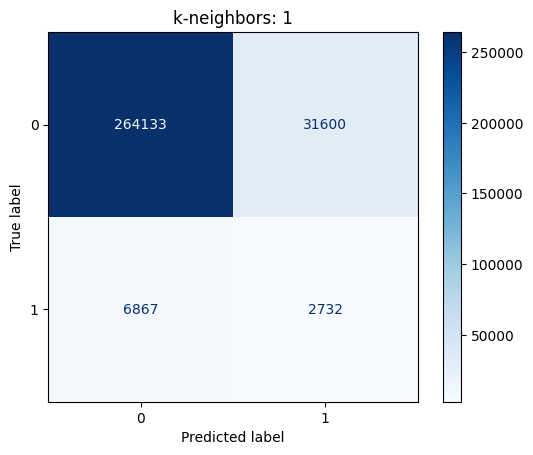

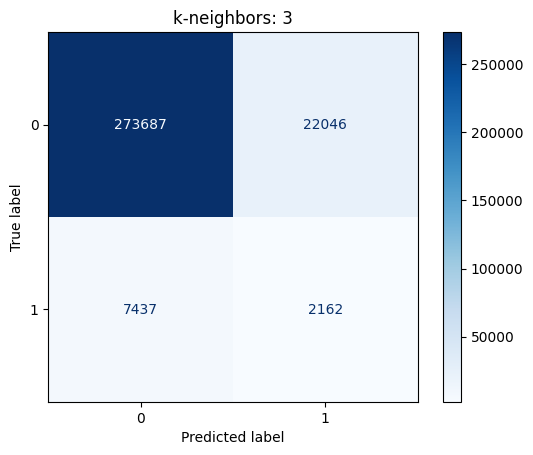

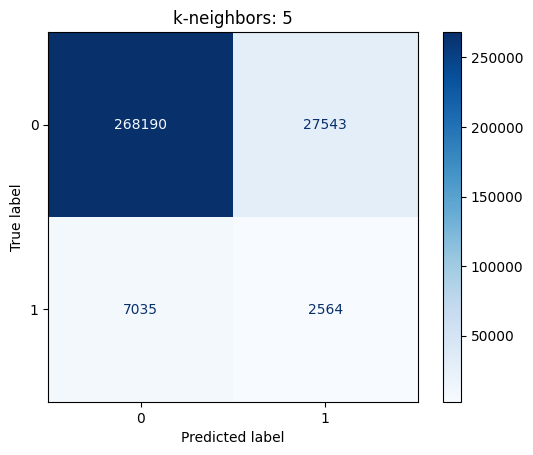

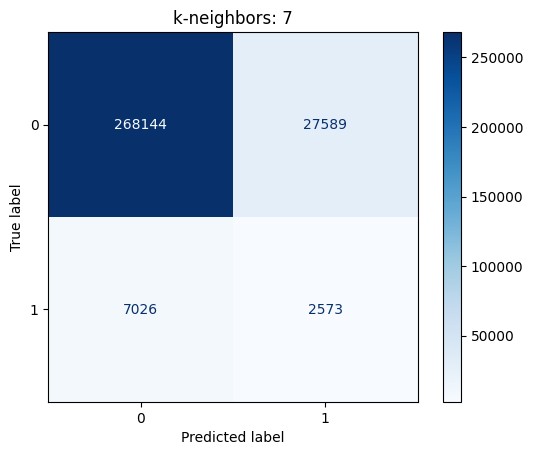

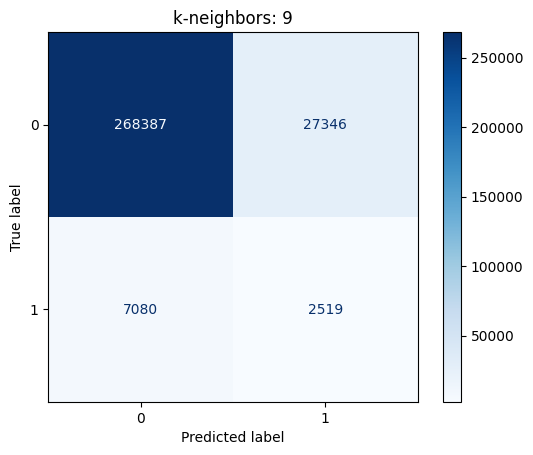

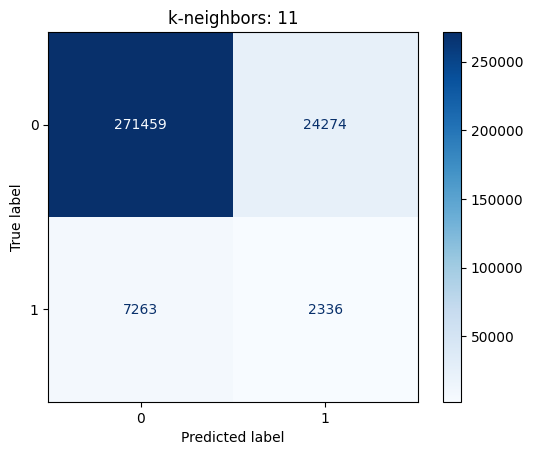

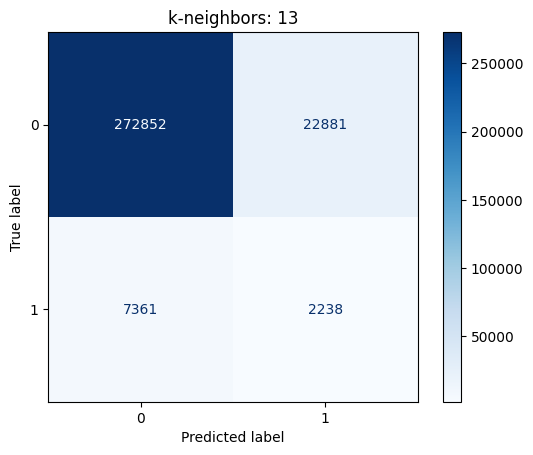

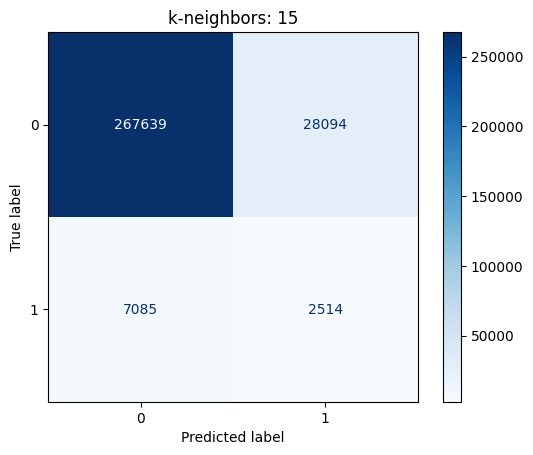

In [49]:
for samp in adasyn_results_list:
    disp = ConfusionMatrixDisplay(confusion_matrix=samp['cm'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'k-neighbors: {samp["k_neighbors"]}')
    plt.show()